# Environment setup

## Imports

In [2]:
# Import Python packages
import os
import time



# Import installed libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print('Tensorflow version', tf.version.VERSION)


2023-08-03 13:35:57.357109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version 2.12.1


## Constants

In [11]:
# Constants
EPOCHS = 20
IMG_HEIGHT = 150
IMG_WIDHT = 150
BATCH_SIZE = 32
INPUT_SHAPE = (150, 150, 3)
VIEW_DATASET_IMAGES = False

# File paths
FIRE_DET_PATH = '/Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection'
DATASET = FIRE_DET_PATH + '/data/'
PRED_DATASET = FIRE_DET_PATH + '/predict/'
FIRE_IMG_PATH = DATASET + '/1'
NO_FIRE_IMG_PATH = DATASET + '/0'
FIRE_IMG = FIRE_IMG_PATH + '/1.jpg'
RAND_IMG = NO_FIRE_IMG_PATH + '/1.jpg'

# Output paths
CHECKPOINT_FILEPATH = FIRE_DET_PATH + '/temp/checkpoint'
KERAS_MODEL = FIRE_DET_PATH + '/model/retrained_imagenet.keras'
HDF5_MODEL = FIRE_DET_PATH + '/model/retrained_imagenet.h5'

print("-" * 80)
print("[INFO] : Constants defined")
print("[DEBUG] : Batch size = ", BATCH_SIZE)
print("[DEBUG] : Epochs = ", EPOCHS)
print("[DEBUG] : Input image height = ", IMG_HEIGHT)
print("[DEBUG] : Input image width = ", IMG_WIDHT)
print("[DEBUG] : Input image shape = ", INPUT_SHAPE)
print(f"[DEBUG] : Saving model checkpoints to {CHECKPOINT_FILEPATH}",)
print(f"[DEBUG] : Saving keras extension model to {KERAS_MODEL}",)
print(f"[DEBUG] : If required, saving HDF5 extension model to {HDF5_MODEL}",)
print(f"[DEBUG] : Prediction images in {PRED_DATASET}",)





--------------------------------------------------------------------------------
[INFO] : Constants defined
[DEBUG] : Batch size =  32
[DEBUG] : Epochs =  20
[DEBUG] : Input image height =  150
[DEBUG] : Input image width =  150
[DEBUG] : Input image shape =  (150, 150, 3)
[DEBUG] : Saving model checkpoints to /Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection/temp/checkpoint
[DEBUG] : Saving keras extension model to /Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection/model/retrained_imagenet.keras
[DEBUG] : If required, saving HDF5 extension model to /Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection/model/retrained_imagenet.h5
[DEBUG] : Prediction images in /Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection/predict/


## Auxiliary Functions

In [4]:
def count_files_in_folders(parent_folder) -> dict:
    """Count files in given folder. Return dictionary with folder and count."""
    folder_names = os.listdir(parent_folder)
    file_count = {}

    for folder_name in folder_names:
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            file_count[folder_name] = len(
                [file for file in os.listdir(folder_path) if os.path.isfile(
                    os.path.join(folder_path, file)
                    )
                ]
            )
        else:
            file_count[folder_name] = 0

    return file_count


def load_and_prep_image(filename, img_shape = 150):
    """Funtion to read image and transform image to tensor."""
    img = tf.io.read_file(filename) #read image
    img = tf.image.decode_image(img) # decode the image to a tensor
    img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
    return img


def pred_and_plot(model, filename, class_names):
    """Funtion to read image and give desired output with image.

    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    if len(pred[0]) > 1: # check for multi-class
        # if more than one output, take the max
        pred_class = class_names[pred.argmax()]
    else:
        # if only one output, round
        pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    sh_image = plt.imread(filename)
    plt.imshow(sh_image)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

    # specifying path to sample image from list of test images.




# Preprocessing

## Get data

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET,
        validation_split = 0.2,
        image_size=(IMG_HEIGHT, IMG_WIDHT),
        batch_size=BATCH_SIZE,
        subset="training",
        seed=50,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET,
        validation_split=0.2,
        image_size=(IMG_HEIGHT, IMG_WIDHT),
        batch_size=BATCH_SIZE,
        subset="validation",
        seed=50,
)

# Verify data
print("-" * 80)
print("[INFO] : BatchDataset type objects returned.")
print("[INFO] : Class names:", train_ds.class_names)



Found 651 files belonging to 2 classes.
Using 521 files for training.
Found 651 files belonging to 2 classes.
Using 130 files for validation.
--------------------------------------------------------------------------------
[INFO] : BatchDataset type objects returned.
[INFO] : Class names: ['0', '1']


## View image data

In [ ]:
# i = 1
for (image, label) in train_ds.take(1):
    # Plot the first 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[label[i]])
        plt.axis("Off")
    plt.show()

print("-" * 80)
print('[INFO] : Showing image from training dataset with 20% validation data.')


## Cache and memory prefeteching

In [6]:
# Use caching and prefetching to optimize loading speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("-" * 80)
print('[INFO] : Autotune setup complete.')

--------------------------------------------------------------------------------
[INFO] : Autotune setup complete.


# Training

## Data augmentation

In [ ]:
# Introduce randomly flipped images to introduce generalization and reduce
# overfitting
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

## Load pretrained ResNet50

In [ ]:
# Using pre-trained Resnet-50 layers model to train on our fire-dataset
# here we are setting include_top as False, as we will add our own dense layers after resnet 50 last layer
pre_trained_resnet_50 = tf.keras.applications.ResNet50(include_top = False,
                                                      input_shape = INPUT_SHAPE,
                                                      pooling = 'avg',
                                                      classes = 100,
                                                      weights = 'imagenet')

# Here we want last 10 layers to be trainable so freezing first 40 layers
x = 0
for layer in pre_trained_resnet_50.layers:
    layer.trainable = False
    x+=1
    if x == 39:
        break

print("-" * 80)
print("[INFO] : Completed importing pre trained RESNET50 model weights.")


## Add training layers

In [ ]:
# Adding extra Dense layers after Resnet 50 last layer, we do this to increase
# our models capability to categorise image as having fire or not having fire
model = Sequential()
model.add(pre_trained_resnet_50)
model.add(Dense(2048, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4000, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()


## Define callbacks and compile model

In [ ]:
# Using tensorflow's learning-rate-scheduler to change learning rate at each epoch
# this will help us to find the best learning rate for our model
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch/20)
)
print("-" * 80)
print("[INFO] : Learning rate callback scheduled.")

# Using tensorflow's ModelCheckpoint to save best model having less validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_FILEPATH, monitor = 'val_loss',
    save_best_only = True,
)
print("-" * 80)
print("[INFO] : Model checkpoint callback scheduled.")

# Using Adam optimizer to optimize our model to better learn on our dataset
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

print("-" * 80)
print("[INFO] : Model compiled using Adam optimizer.")



## Train and save model

In [ ]:
# Train model
print("-" * 80)
print("[INFO] : Starting model fitting with callbacks.")
# Now time to train our model on fire dataset
model_hist = model.fit(train_ds, validation_data = test_ds,
        epochs = EPOCHS,
        callbacks = [learning_rate_callback,  model_checkpoint_callback,],
)

# Save model parameters
try:
    print("[INFO] : Trying to save a .keras format model.")
    model.save(KERAS_MODEL)
    print("[INFO] : Saved .keras model successfully.")
except Exception as ex:
    print(ex)
    print("[INFO] : Trying to save a HDF5 model format.")
    model.save(HDF5_MODEL,)
    print("[INFO] : Saved .h5 model successfully.")



## Plot loss graph

In [ ]:
# Creating graph to visualzie how our model performed at different learning rate and its loss.
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
# Plot the loss in log scale
plt.semilogx(lrs, model_hist.history["loss"])
plt.tick_params(
    'both',
    length=10,
    width=1,
    which='both'
) # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 1]) # Set the plot boundaries



# Model evaluation

In [7]:
# Run the model on the test dataset
model_hist.evaluate(test_ds)

NameError: name 'model_hist' is not defined

# Testing

# Load model

In [8]:
# Load custom retrained ResNet50 model
loaded_model = tf.keras.models.load_model(KERAS_MODEL)
easy_class_labels = ['Fire not found in image', 'Fire']


## Make predictions using loaded model

In [12]:
fire_images: list = os.listdir(FIRE_IMG_PATH)
no_fire_images: list = os.listdir(NO_FIRE_IMG_PATH)
pred_imgs: list = os.listdir(PRED_DATASET)


print('Fires dataset size:\t', len(fire_images))
print('Random images dataset size:\t', len(no_fire_images))
print('Unseen real world image dataaset size:\t', len(pred_imgs))



Fires dataset size:	 110
Random images dataset size:	 541
Unseen real world image dataaset size:	 9


Randomly generated index number:	 4
Running model on image 	 (ball-park-brand-MflMvzNfdQ8-unsplash.jpg)
Image path	 (/Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection/predict/ball-park-brand-MflMvzNfdQ8-unsplash.jpg)
1/1 [==============================] - 1s 1s/step


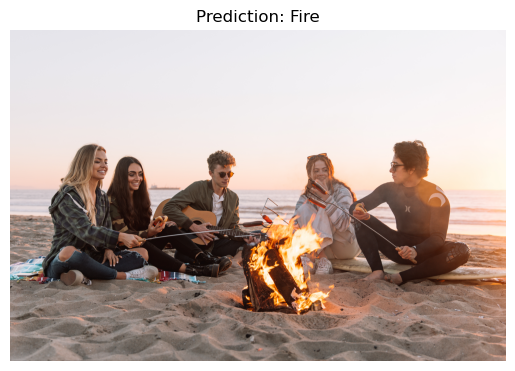

In [21]:
# randomizer = [fire_images, no_fire_images]
# randomizer_idx = np.random.randint(0, 2, dtype=int)
# test_type = randomizer[randomizer_idx]
# if randomizer_idx == 0:
#     print('Testing non fire images')
# else:
#     print('Testing fire images')

# rand_test_image_idx = np.random.randint(0, len(test_type) + 1, dtype=int)
# rand_test_image_path = NO_FIRE_IMG_PATH + f'/{no_fire_images[rand_test_image_idx]}'
# print(type(randomizer))
# print(randomizer_idx)

# Generate random index number from range of list indices
rand_test_image_idx = np.random.randint(0, len(pred_imgs), dtype=int)
rand_test_image_path = PRED_DATASET + f'{pred_imgs[rand_test_image_idx]}'


print('Randomly generated index number:\t', rand_test_image_idx)
print(f'Running model on image \t ({pred_imgs[rand_test_image_idx]})')
print(f'Image path\t ({rand_test_image_path})')
time.sleep(3)

# Generate predictions
pred_and_plot(loaded_model, rand_test_image_path, easy_class_labels)


In [14]:
# Command to convert ipynb to py script ext
# !jupyter nbconvert --to script resnet-fire-det.ipynb

[NbConvertApp] Converting notebook resnet-fire-det.ipynb to script
[NbConvertApp] Writing 10836 bytes to resnet-fire-det.py
